<h1 style="font-family: monospace; color: orange; text-align: center; font-size: 50px;"> 
    Poker Player Patterns
</h1><br />

The data is sourced from [here](https://www.kaggle.com/smeilz/poker-holdem-games#Export%20Holdem%20Manager%202.0%2012292016131233.txt), specific file used is 
<span style="color: black; color: FireBrick;">
    Export Holdem Manager 2.0 12302016144830.txt
</span>.

The file holds the information about over 40 000 rounds of poker played on a table with 9 players. Those are represented as poker server output, streamed to our player named 
IlxxxlI. We know his cards at every turn, though we only sometimes learn about other players cards at the end.

## Environment settings
We will use a couple of libraries, with outside dependancies being `matplotlib`, `networkx` and `pandas`. From our library we will require the enums as they identify some data inside .csv file and some functions which offer support for parsing hands (give us information about whether player has a pair, straight, flush, ...), which  we will use later on. 

Further we will set some constants that will be used throughout the notebook.

In [350]:
from IPython.display import display
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from lib import (
    getHand, straightOuts, flushOut,
    ActionId, TurnId, Hand
)

# rounds gathered (last one is not finished)
MAX_ROUND = 42688 - 1
# user that provided the data (sometimes deviates highly)
MAIN_USER = 'IlxxxlI'

nrowdisplay = 10
max_round = MAX_ROUND

warnings.filterwarnings('ignore')
pd.options.display.max_rows = nrowdisplay

# monkeypatch ungroup to pandas
pd.core.frame.DataFrame.ungroup = (
    lambda self: self.reset_index().drop(
        columns = ['level_0', 'level_1', 'level_2'],
        errors = 'ignore'
    )
)

# default ax configuration
def setAxConfig(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
# card representation in .csv files is informative, 
# though not practical when applying algorithms, 
# therefore we will need some conversion support
card_vals = list(map(str, range(2, 11))) + list('JQKA')
card_val_idx = dict(zip(card_vals, range(13)))

## Loading csv
Here we load the parsed and later tidied data. <br />
Because we are loading many files and have to do similar things for each one, there is a loop that takes care of all and also reduces readability. <br />

In [351]:
load_path = Path.cwd() / 'tidy_data'

for file in load_path.iterdir():
    data = pd.read_csv(file)
    if 'round_id' in data.columns:
        data = data[data.round_id <= max_round]
    globals()[file.stem] = data

user_dict = list(user_ids.user)
main_user_id = user_dict.index(MAIN_USER)

## Card Strength
We will evaluate strength of various card combinations.<br />
This includes checking how many times and how much on average has user won when dealt a specific pair of cards

### Basic Preparation
Data frame `received_cards` holds the information about which cards IlxxxlI has received, while `cardshow` tells us how much a specific player has won at round's end. We need to merge those to have a layout to see how much IlxxxlI has won when given certain cards.

In [352]:
card_wins = received_cards.merge(
    cardshow[cardshow.user_id == main_user_id], 
    'inner', 'round_id'
).groupby(
    ['card1', 'card2']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_won': [df.winnings.mean()],
            'times_won': [(df.winnings > 0).sum()]
        }
    )
).ungroup().sort_values(
    by = ['avg_won', 'times_won'], 
    ascending = False
)

In [353]:
display(card_wins.head(8))
display(card_wins.tail(8))

,card1,card2,avg_won,times_won
1235,A♥,A♦,10.289474,33
1281,J♥,J♦,7.145714,25
1300,K♠,K♦,6.827674,34
1206,A♠,A♣,6.728049,35
1323,Q♣,Q♥,5.813750,28
1324,Q♣,Q♦,5.638261,21
1311,K♥,K♦,5.502414,24
1255,A♦,K♦,5.296538,24


,card1,card2,avg_won,times_won
1173,9♥,9♦,-2.497931,16
1301,K♠,Q♠,-2.559667,17
193,10♦,K♦,-2.608462,17
1298,K♠,K♣,-3.510789,28
1052,8♠,8♦,-3.831154,11
1299,K♠,K♥,-3.999333,35
754,5♣,J♣,-4.099167,2
1254,A♦,K♥,-4.227879,25


Above data frames show us the top / bottom 8 card pairs, ordered by the `avg_won` column. This means the 8 most and 8 least profitable combinations.

What we notice here is that while AA and KK are usually the winning combo, KK is also near the bottom. The reason for this is probably the overly confident nature of players that are dealt those cards before the flop.

### Pair Analysis
Our goal here is to see how much being dealt a pair (eg. AA) differs from other combinations.<br />
Lets visualise the correlation between winning more often and winning more on average, while also representing paired dealt cards.

First we will create a grouping for paired values `grouped_cards`. Then so we can draw every paired value seperately.

In [354]:
is_pair = card_wins.apply(
    lambda row: [row.card1[:-1] == row.card2[:-1]],
    axis = 1, result_type = 'expand'
)[0]

grouped_cards = card_wins[is_pair].assign(
    group_key = card_wins.apply(
        lambda row: [card_val_idx[row.card1[:-1]]],
        axis = 1, result_type = 'expand'
    )
)

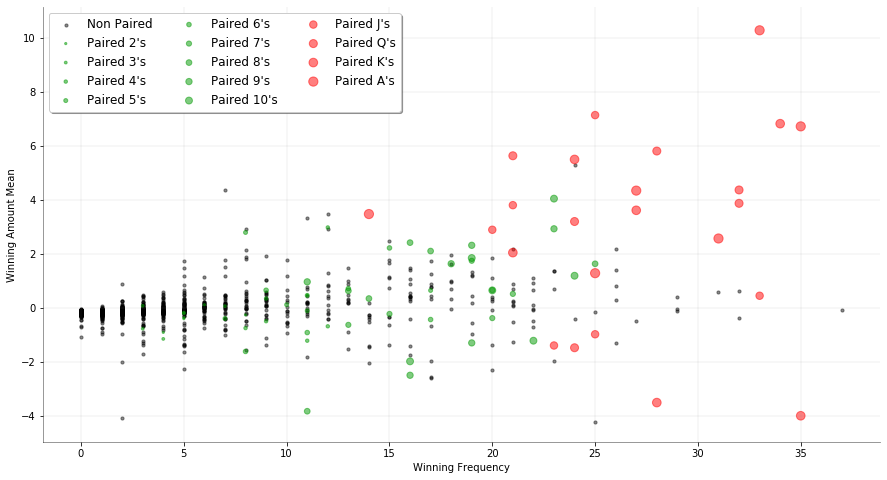

In [355]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
setAxConfig(ax, '', 'Winning Frequency', 'Winning Amount Mean')

ax.scatter(
    card_wins[~is_pair].times_won, card_wins[~is_pair].avg_won,
    s = 10, c = 'black', label = 'Non Paired', alpha=0.45
)

for key, group in grouped_cards.groupby('group_key'):
    ax.scatter(
        group.times_won, group.avg_won,
        s = pow(key + 4, 2) // 3, alpha = 0.5,
        c = [(key >= 9, 0.6 * (key < 9), 0)] * len(group),
        label='Paired ' + card_vals[key] + '\'s'
    )
    
ax.legend(loc='upper left', shadow=True, fontsize=12, ncol=3);

We can see that winnings more often does not necessarily mean winning more on average. Regarding paired values, they really do bring profit more regularly, and most of the big, red dots, which represent high pairs, are correlated positively, while also being highly valued on both axes, which tells us that playing them we are on average going to win more and more often.

### Value Combination Analysis
We wish to see which values work best together. For the sake of simplicity we are going to neglect suit info (card color). Visualisation will be done with the `networkx` package. We plan to color the connections with either red or green color. Red will represent the losing combinations (card pairs, which have < 0 winning average) while green will represent the profitable combinations (card pairs, which have > 0 winning average). The darker color shades will be applied to connections, with more extremal winning values. Because we won't draw self-loops their colors will be inherited by nodes.

First we must create a new data frame which will store only the values of the two dealt cards. We will group the cards with the same values together and calculate their winning average (when tidying data we made sure that columns `card1` and `card2` are ordered, so that AK will be the same as KA as the order of cards being dealt does not matter).

In [356]:
card_values = card_wins.apply(
    lambda row: pd.Series([
        row.card1[:-1], row.card2[:-1],
        row.avg_won, row.times_won
    ], index = ['val1', 'val2',  'avg_won', 'times_won']), 
    axis = 1, result_type = 'expand'
).groupby(
    ['val1', 'val2']
).apply(
    lambda df: pd.DataFrame(
        data = {
            'avg_won': [df.avg_won.mean()],
            'times_won': [df.times_won.sum()]
        }
    )
).ungroup()

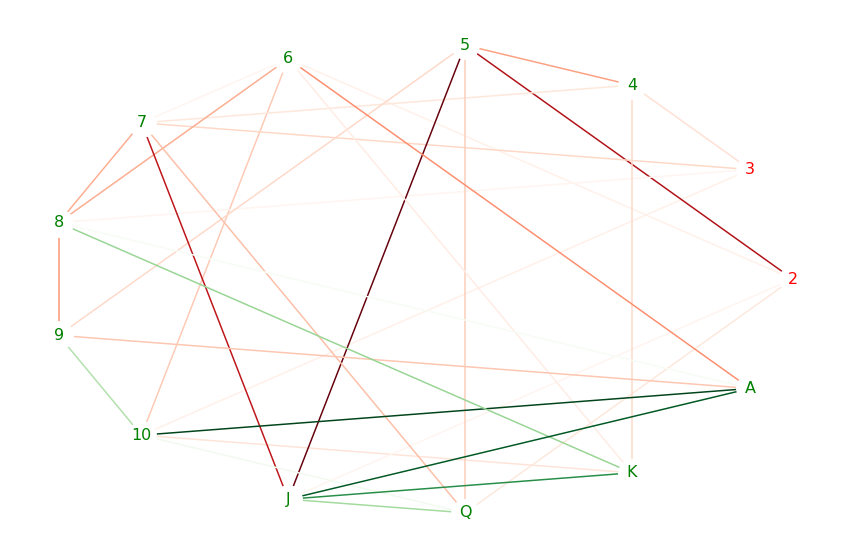

In [357]:
is_pair = card_values.val1 == card_values.val2

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
G = nx.Graph()
G.add_nodes_from(range(13))
layout = nx.circular_layout(G)

data = [([], []), ([], [])]
for i, row in card_values[~is_pair].iterrows():
    i1 = card_val_idx[row.val1]
    i2 = card_val_idx[row.val2]
    G.add_nodes_from([i1, i2])
    if abs(row.avg_won) > 0.15: # graph density control
        G.add_edge(i1, i2)
        data[row.avg_won > 0][0].append((i1, i2))
        data[row.avg_won > 0][1].append(abs(row.avg_won))

for (edges, colors), cm in zip(data, [plt.cm.Reds, plt.cm.Greens]):
    nx.draw(
        G, layout, ax = ax, 
        node_size=750, node_color='white',
        edgelist=edges, edge_color=colors,
        width=1.5, edge_cmap=cm
    )
    
pairs = card_values[is_pair]
node_coloring = [dict(), dict()]
for val, won in zip(pairs.val1, pairs.avg_won):
    idx = card_val_idx[val]
    if won > 0: node_coloring[1][idx] = val
    if won < 0: node_coloring[0][idx] = val

for nodes, color in zip(node_coloring, ['red', 'green']):
    nx.draw_networkx_labels(
        G, layout, nodes, ax = ax,
        font_size = 16, font_color = color
    );

As before we see that having a pair usually pays off, while playing with Jack can be as extremely profitable as it can be unprofitable. That may be because Jacks can usually convince a player to buy into the game even when their second card is a low value, which rarely works out when playing against 9 players.

Further it is interesting to see that high pairs like AK and KQ are pretty neutral. We saw some indications of this already at the beginning as AK was on the top 8 most profitable and also at the bottom 8. This means those combinations have an incredibly large variance which seems to even out in the end.

Focusing again on paired values, we see that basically every pair has a positive profit, except 2's and 3's, which makes sense as they are the lowest of all values.

## Bluff Payoff
In this section we aim to capture the actions of IlxxxlI, which we consider to be bluffs. To characterise an action as a bluff we will demand it satisfies 3 axioms:
- the player has to raise at least 10 * big blind value,
- the player's cards do not add a level when combined with the board,
- the player is not waiting for a flush or a straight to be made.

For this we will require multiple data frames. 

The first, `actions`, stores every action a player has taken. It has id rows as `round_id` and `user_id` with information rows as `action_id`, `amount` and `turn`. `action_id` gives us an index ofan action that was taken by a player (fold, call, check, bet, raise, allin). `amount` is useful if a player raised, bet, called or gone all in, in which case it tells us how much money was involved. `turn` tells us at which turn (preflop, flop, turn, river) the action has occured.

The second, `blinds` gives us information about which player payed which blind (big / small) and the value of blinds at each round (they are not constant).

Below we start by merging blind values with the actions

In [358]:
action_blinds = blinds[
    blinds.blind_type_id == 1
].drop(
    columns = ['user_id']
).merge(
    actions[actions.user_id == main_user_id], 
    'inner', 'round_id'
).rename(
    columns = dict(value = 'blind_value')
)

Now we will merge the cards which IlxxxlI received with the ones on board at each turn.

In [359]:
main_player_cards = received_cards[
    received_cards.user_id == main_user_id
].assign(
    hand = received_cards.card1 + ' ' + received_cards.card2
).drop(
    columns = ['card1', 'card2', 'user_id']
).merge(
    board, 'inner', 'round_id'
)

Finally we can satisfy the first axiom and also filter the data frame `action_blinds` to contain only the occasions when player raised. Then we merge the data frame from above to get the one data frame we will use.

In [360]:
bluff_data = action_blinds[
    (action_blinds.amount > 10 * action_blinds.blind_value) &
    ((action_blinds.action_id == ActionId.RAISE) | 
     (action_blinds.action_id == ActionId.BET) |
     (action_blinds.action_id == ActionId.ALLIN)
    )
].merge(
    main_player_cards, 'inner', ['round_id', 'turn_id'],
).drop(
    columns = ['user_id', 'blind_type_id', 'action_id', 'turn_id']
)

Now for the second axiom, we must check that player's cards do not add a level to the board. This means that if we have a straight on the board then, when we add our player's cards to the mix there is not going to be any improvement (eg. full house). For this purpuse we have a function in our library that fetches us hand level index when given a hand (series of cards). The hand indexes are described by the Hand enum.

In [327]:
full_board = bluff_data.hand + ' ' + bluff_data.board

strengths = bluff_data.assign(
    handstrength = list(map(getHand, full_board)),
    boardstrength = list(map(getHand, bluff_data.board)),
)
strengths[[
    'blind_value', 'amount', 'hand', 
    'board', 'handstrength', 'boardstrength'
]].sample(5)

,blind_value,amount,hand,board,handstrength,boardstrength
373,1.00,15.63,3♦ 7♦,5♦ J♦ Q♠ 7♥,1,0
553,0.25,5.25,5♣ 5♥,J♠ 5♠ 4♠ Q♦,3,0
210,0.25,8.47,10♥ J♣,8♠ 10♠ 5♣ 2♣,1,0
727,0.25,8.06,J♠ K♣,8♠ 10♦ 2♦ K♥ 4♥,1,0
48,0.50,6.50,5♣ 7♣,4♦ 5♠ Q♥,1,0


Now for the last axiom we have to see if a player is waiting for a flush or straight to be made. Again in our library there are two functions: `straightOuts` and `flushOut`. The first tells us how many values gives us a straight (eg. if we have values (A, 3, 4, 5, 6) there are two cards 2 and 7 that give us a straight). The second returns whether the maximum number of same suited cards given is four, in which case we are waiting for one more.

In [328]:
strengths = strengths.assign(
    straightouts = list(map(straightOuts, full_board)),
    flushouts = list(map(flushOut, full_board))
)
strengths[[
    'blind_value', 'amount', 'hand', 
    'board', 'handstrength', 'boardstrength',
    'straightouts', 'flushouts'
]].sample(5)

,blind_value,amount,hand,board,handstrength,boardstrength,straightouts,flushouts
632,0.5,14.50,5♥ A♥,7♣ 3♥ 2♥ 7♦,1,1,1,1
275,2.0,50.00,2♥ 5♥,9♠ 9♦ 7♥ 4♥,1,1,0,1
458,1.0,44.15,J♣ J♥,7♦ J♦ 7♥ A♥ 8♠,6,1,0,0
634,0.5,14.18,A♠ Q♠,3♠ K♠ A♦ J♥,1,0,1,1
265,2.0,22.00,7♥ K♥,7♦ K♣ 5♠ 9♠ J♠,2,0,0,0


We will say that a betting player is confident in his chances to get the straight or flush if:
- turn index is 1 (two cards left to be shown) and there is hope of a flush or a straight,
- turn index is 2 (one card left to be shown) and there are two cards that can give him a straight.

Now we have the means to satisfy all three axioms in one table.

In [329]:
pure_bluffs = strengths[
    (strengths.handstrength == strengths.boardstrength) & ~( 
        (
            (strengths.turn == TurnId.FLOP) & (
                (strengths.straightouts >= 1) |
                (strengths.flushouts == 1)
            )
        ) | (
            (strengths.turn == TurnId.TURN) & 
            (strengths.straightouts == 2)
        )
    )
].drop(
    columns = [
        'handstrength', 'boardstrength',
        'straightouts', 'flushouts'
    ]
).rename(
    columns = dict(amount = 'raised_by')
)

In [330]:
pure_bluffs[[
    'blind_value', 'raised_by', 'hand', 'board'
]].sample(5)

,blind_value,raised_by,hand,board
236,1.00,28.93,4♠ 5♠,7♣ 6♦ 4♦ 3♦ 5♥
328,0.25,5.00,J♠ Q♠,4♥ 8♦ 6♠
108,0.25,3.25,9♦ J♦,Q♦ 5♣ 6♥
474,0.25,11.46,10♦ A♠,J♥ 3♣ 4♦ 9♣ 4♠
49,0.50,6.00,J♣ Q♠,10♥ A♣ 3♦ 3♠


Those hands do seem as real bluffs so lets see how much profit they brought.

In [332]:
bluff_winnings = pure_bluffs.merge(
    cardshow[cardshow.user_id == main_user_id], 
    'inner', 'round_id'
).drop(
    columns = ['user_id']
).rename(
    columns = dict(amount = 'winnings')
).sort_values(
    by = 'turn'
)

Number of all bluffs: 120
Number of positive bluffed winnings: 77
Average winnings: -0.01621545459039897
Average bluffed winnings: -1.7307499999999998


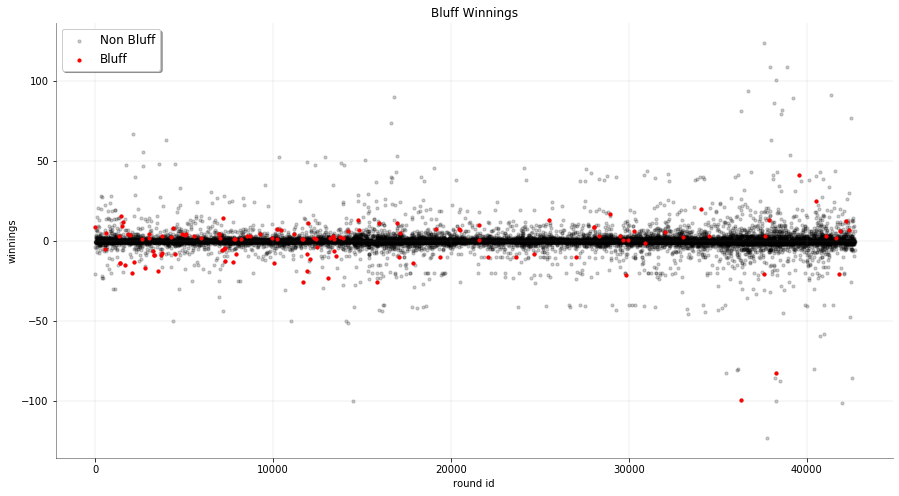

In [333]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
setAxConfig(ax, 'Bluff Winnings', 'round id', 'winnings')

user_winnings = cardshow[
    (cardshow.user_id == main_user_id) &
    (cardshow.winnings != 0)
]

ax.scatter(
    user_winnings.round_id, user_winnings.winnings,
    c = 'black', s = 10, alpha = 0.2, label = 'Non Bluff'
)
ax.scatter(
    bluff_winnings.round_id, bluff_winnings.winnings,
    c = 'red', s = 10, alpha = 1, label = 'Bluff'
)
ax.legend(loc='upper left', shadow=True, fontsize=12)

print('Number of all bluffs:', bluff_winnings.winnings.size)
print(
    'Number of positive bluffed winnings:',
     bluff_winnings[bluff_winnings.winnings > 0].winnings.size
)
print('Average winnings:', user_winnings.winnings.mean())
print('Average bluffed winnings:', bluff_winnings.winnings.mean())

Our player did not bluff very often. When he did he mostly successeded, though the times he did not seemed to beat his average winnings bellow 0. 